## Load and transform data

### Load libraries

In [213]:
# conda install pandas
# conda install xlrd
# conda install openpyxl
# conda install numpy
# pip install sktime[all_extras]

# Main libraries

import pandas as pd
import numpy as np
import sktime as sktime
import warnings

# Get functions from sktime

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS

# Models

from sklearn.neighbors import KNeighborsRegressor

# Filter warnings

warnings.filterwarnings("ignore")

### Hyperparameters

In [214]:
# Variable to forecast
    
selected_var = "car"

# Parameters

test_size = 0.20

# Season cycle

season_cycle = 12

### Load data

In [215]:
data = pd.read_excel("Output/data_ready.xlsx")
number_rows = data['Date'].count()

### Parameters

In [216]:
# Results table

optim_models = pd.DataFrame()
    
# Time series
    
# Wrangling

df = data[['Date',selected_var]]
df[selected_var] = df[selected_var].astype(np.float64)
ts = pd.Series(df[selected_var].values, index = pd.date_range(min(df['Date']), freq = 'M', periods = number_rows))

# Total size
    
number_points = ts.count()
number_split = int(number_points*test_size)
    
# Y train and Y test
    
y_train, y_test = temporal_train_test_split(ts, test_size = number_split)

# As numeric 

y_train = pd.to_numeric(y_train)
y_test = pd.to_numeric(y_test)
    
# Horizon
    
fh = np.arange(len(y_test))+1

fh = pd.to_numeric(fh)

### Train and test

In [217]:
print("Observations in train: ", number_points - number_split)
print("Observations in test: ", number_split)

Observations in train:  164
Observations in test:  40


### Optimization

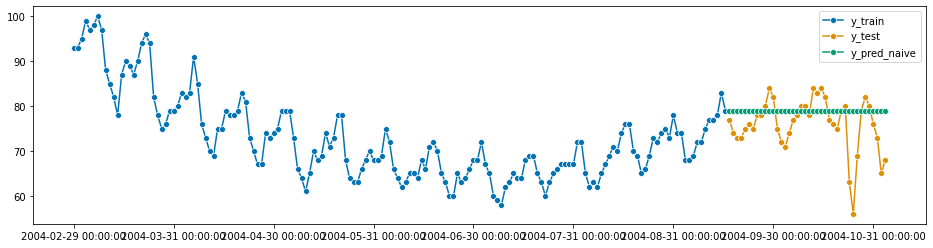

In [218]:
# Naive

forecaster_naive = NaiveForecaster(strategy="last")
forecaster_naive.fit(y_train)
y_pred_naive = forecaster_naive.predict(fh)
    
# Save results
    
optim_plot_naive = plot_series(y_train, y_test, y_pred_naive, labels=["y_train", "y_test", "y_pred_naive"])
optim_plot_naive
smape_naive = smape_loss(y_pred_naive, y_test)

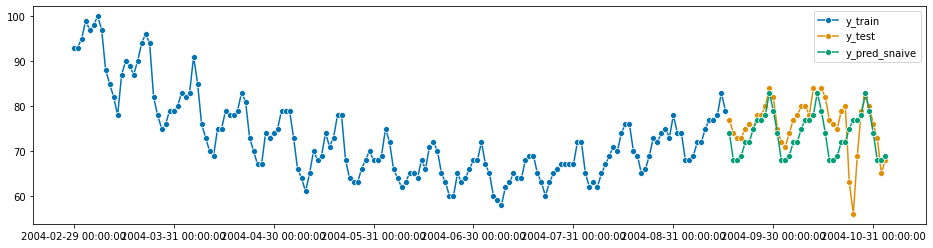

In [219]:
# Snaive

forecaster_snaive = NaiveForecaster(strategy="last", sp = season_cycle)
forecaster_snaive.fit(y_train)
y_pred_snaive = forecaster_snaive.predict(fh)
    
# Save results
    
optim_plot_snaive = plot_series(y_train, y_test, y_pred_snaive, labels=["y_train", "y_test", "y_pred_snaive"])
optim_plot_snaive
smape_snaive = smape_loss(y_pred_snaive, y_test)

In [220]:
# Exp Smoothing

forecaster_exp = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
# forecaster_exp.fit(y_train)
# y_pred_exp = forecaster_exp.predict(fh)
    
# Save results
    
# optim_plot_exp = plot_series(y_train, y_test, y_pred_exp, labels=["y_train", "y_test", "y_pred_exp"])
# optim_plot_exp
# smape_exp = smape_loss(y_pred_exp, y_test)

In [221]:
# ETS

forecaster_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
# forecaster_ets.fit(y_train)
# y_pred_ets = forecaster_ets.predict(fh)
    
# Save results
    
# optim_plot_ets = plot_series(y_train, y_test, y_pred_ets, labels=["y_train", "y_test", "y_pred_ets"])
# optim_plot_ets
# smape_exp = smape_loss(y_pred_exp, y_test)

In [222]:
# Arima

forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
# forecaster_arima.fit(y_train)
# y_pred_arima = forecaster_arima.predict(fh)
    
# Save results
    
# optim_plot_arima = plot_series(y_train, y_test, y_pred_snaive, labels=["y_train", "y_test", "y_pred_arima"])
# optim_plot_arima
# smape_arima = smape_loss(y_pred_arima, y_test)

In [223]:
# Ensemble

forecaster_ensemble = EnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend="add", damped=False, seasonal="multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped=True, seasonal="multiplicative", sp=12
            ),
        ),
    ]
)

# forecaster_ensemble.fit(y_train)
# y_pred_ensemble = forecaster_ensemble.predict(fh)
    
# Save results
    
# optim_plot_ensemble = plot_series(y_train, y_test, y_pred_snaive, labels=["y_train", "y_test", "y_pred_ensemble"])
# optim_plot_ensemble
# smape_ensemble = smape_loss(y_pred_ensemble, y_test)

In [224]:
# Reduced regression

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster_reg = ReducedRegressionForecaster(
    regressor = regressor, window_length=15, strategy="recursive"
)
param_grid = {"window_length": [5, 10, 15]}

# Optim

# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
# gscv = ForecastingGridSearchCV(forecaster_reg, cv=cv, param_grid=param_grid)
# gscv.fit(y_train)
# y_pred_reg = gscv.predict(fh)

# optim_plot_reg = plot_series(y_train, y_test, y_pred_snaive, labels=["y_train", "y_test", "y_pred_reg"])
# optim_plot_reg
# smape_reg = smape_loss(y_pred_reg, y_test)

# Best window

# gscv.best_params_

In [225]:
# Theta

forecaster_theta = ThetaForecaster(sp=12)
# alpha = 0.05  # 95% prediction intervals
# y_pred, pred_ints = forecaster_theta.predict(fh, return_pred_int=True, alpha=alpha)
    
# Save results
    
# optim_plot_theta = plot_series(y_train, y_test, y_pred_snaive, labels=["y_train", "y_test", "y_pred_theta"])
# optim_plot_theta
# smape_theta = smape_loss(y_pred_theta, y_test)